# Цель Блокнота

Посмотрим на бустинг от Яндекса.
Необходимо установить с помощью команды `!pip install`

[Документация по CatBoost](https://catboost.ai/en/docs/)

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.3 MB/s eta 0:00:00


# Import библиотек

In [ ]:
import pandas as pd # Библиотека Pandas для работы с табличными данными
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import seaborn as sns # библиотека seaborn для визуализации
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего

In [ ]:
plt.style.use('dark_background') # для модных черных рисунков

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Набор данных



Набор данных представляет собой статистику признаков автомобилей на вторичном рынке в Молдавии.

Набор включает ряд категориальных и численных значений, составляющих одну запись (строку). Число записей можно найти как число строк.

Каждый столбец в записи — это отдельный признак.

Среди указанных признаков приведен целевой для задачи предсказания (регрессии) - цена автомобиля.

 Также среди признак есть целевой для задачи классификации - тип трансмиссии.

 Последняя задача может быть рассмотрена, например, как пример задачи на заполнение пропусков (если продавец не указал соответствующий признак).

# Загрузка данных

Загружаем наши данные из файла по прямой ссылке на GitHub

In [ ]:
DF = pd.read_csv('https://raw.githubusercontent.com/dayekb/mpti_ml/main/data/cars_moldova_no_dup_no_outliers.csv', delimiter = ',')
DF

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0
...,...,...,...,...,...,...,...,...,...
32480,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0
32481,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0
32482,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0
32483,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0


Список числовых и категориальных данных

In [ ]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)']

# Подготовка данных

In [ ]:
from sklearn.model_selection import train_test_split#  функция разбиения на тренировочную и тестовую выборку
# в исполнении scikit-learn
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
from sklearn.model_selection import cross_validate # функция кросс-валидации от Scikit-learn

from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn

from sklearn.metrics import PredictionErrorDisplay # Класс визуализации ошибок модели

**Считываем данные, разбиваем на тренировочную и валидационную**

In [ ]:
# не забываем удалить целевую переменную цену из признаков
X, y = DF.drop(columns = ['Price(euro)']), DF['Price(euro)']
features_names = list(DF.drop(columns = ["Price(euro)"]).columns)

# разбиваем на тренировочную и валидационную
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

[Принято сохранять данные в формате Pool](https://catboost.ai/en/docs/concepts/python-reference_pool)

Особый класс хранения данных "чтобы было быстрее"

Плюс можно настроить баланс классов и т.д.

In [ ]:
from catboost import Pool

In [ ]:
train_data_reg = Pool(
    data=X_train,
    label=y_train,
    cat_features = cat_columns,
    feature_names=features_names,
)

eval_data_reg = Pool(
    data=X_val,
    label=y_val,
    cat_features = cat_columns,
    feature_names=features_names
)

## Модель

Для [регрессии](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor)

In [ ]:
from catboost import CatBoostRegressor

Создаем Класс, как обычно

Ключевые настройки:

* `iterations` - количество деревьев / итераций обучения

* `objective`- функция потерь, которую надо минимизировать при обучении. Есть показатели для регрессии (среднеквадратичная ошибка), есть для классификации (`logloss`).
* `eval_metric` - валидационная метрика, используемая для обнаружения переобучения и ранней остановки;
* `early_stopping_rounds` - число итераций до остановки, если на их протяжении метрика качества не улучшалась по сравнению с оптимальной;
* `cat_features` - список категориальных признаков (чтобы модель сделала свой TargetEncoder внутри)
* `depth` - глубина дерева  (по умолчанию 6, максимальное значение - 16)
* `verbose` - объем выводимой информации (выдавливать ответ каждые n итераций)
* `random_state` – фиксируем сид для воспроизводимости;





In [ ]:
model_reg = CatBoostRegressor(iterations = 1000,
                           early_stopping_rounds=100,
                           verbose = 100,
                           cat_features = cat_columns,
                           depth = 3,
                              objective  = 'MAE',
                           eval_metric= 'MAE',
                              random_state = 42
                           )


Применяем метод `fit` по традиции

In [ ]:
model_reg.fit(X=train_data_reg,
          eval_set=eval_data_reg,
          )

0:	learn: 5223.8951819	test: 5313.1698105	best: 5313.1698105 (0)	total: 117ms	remaining: 1m 57s
100:	learn: 2454.2834501	test: 2511.2587814	best: 2511.2587814 (100)	total: 3.62s	remaining: 32.2s
200:	learn: 2159.5455992	test: 2192.0149304	best: 2192.0149304 (200)	total: 6.22s	remaining: 24.7s
300:	learn: 2044.8398003	test: 2065.4134492	best: 2065.4134492 (300)	total: 9.23s	remaining: 21.4s
400:	learn: 1977.1651491	test: 1995.5158943	best: 1995.5158943 (400)	total: 11.8s	remaining: 17.6s
500:	learn: 1929.6857218	test: 1948.3261610	best: 1948.3261610 (500)	total: 14.9s	remaining: 14.8s
600:	learn: 1900.6950133	test: 1921.4009347	best: 1921.4009347 (600)	total: 18.3s	remaining: 12.1s
700:	learn: 1878.7606476	test: 1902.4243459	best: 1902.4243459 (700)	total: 21.1s	remaining: 9.01s
800:	learn: 1858.7548595	test: 1885.4834231	best: 1885.4834231 (800)	total: 23.7s	remaining: 5.89s
900:	learn: 1842.8718348	test: 1873.1965049	best: 1873.1965049 (900)	total: 26.6s	remaining: 2.93s
999:	learn: 1

Поскольку в качестве лучше итерации (`bestIteration`) указана последняя, то наверное можно повторить процедуру обучения с большим числом итераций

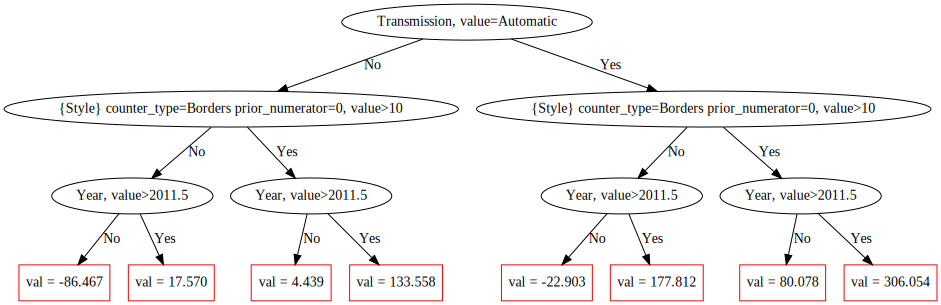

In [ ]:
#@title Глубина дерева для Отрисовки{ run: "auto" }
tree_idx=5 #@param {type:"slider", min:0, max:25, step:1}

model_reg.plot_tree(tree_idx=tree_idx,
                pool = train_data_reg)

**История обучения**

In [ ]:
results = model_reg.evals_result_

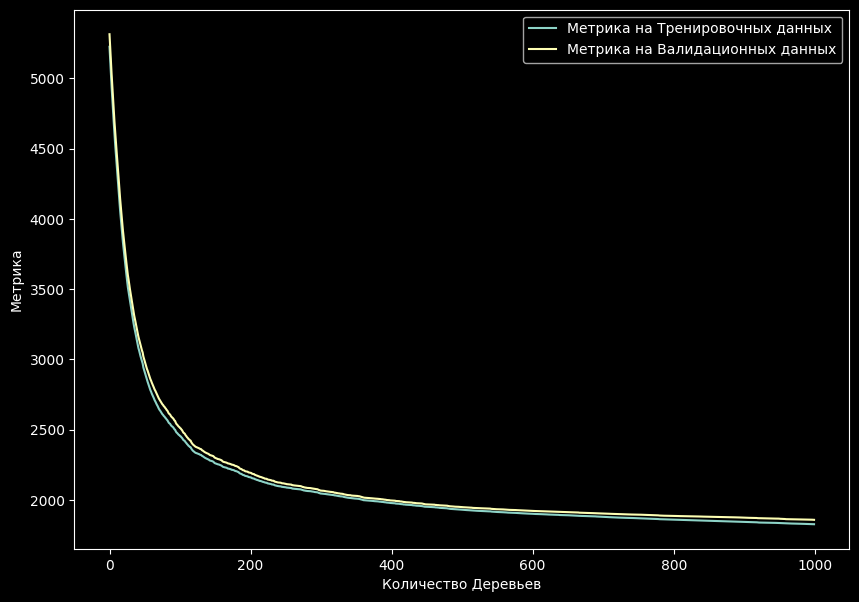

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(results["learn"]["MAE"], label="Метрика на Тренировочных данных")
plt.plot(results["validation"]["MAE"], label="Метрика на Валидационных данных")
plt.xlabel("Количество Деревьев")
plt.ylabel("Метрика")
plt.legend();

## Визуализация значимости признаков

In [ ]:
def feature_importance_plotter(model, features_names):
    """Отрисовка значимости признаков в виде горизонтальных столбчатых диаграмм.
    Параметры:
    ===========
    model: модель
    features_names: список имен признаков
    """
    feature_importance = model.feature_importances_

    sorted = np.argsort(feature_importance)

    ypos = np.arange(len(features_names))

    fig= plt.figure(figsize=(8,4))
    plt.barh(ypos, feature_importance[sorted])
    #plt.xlim([0,1])
    plt.ylabel('Параметры')
    plt.xlabel('Значимость')
    plt.yticks(ypos,features_names[sorted] );

Важно отметить, что по умолчанию - значимость не нормируется на единицу

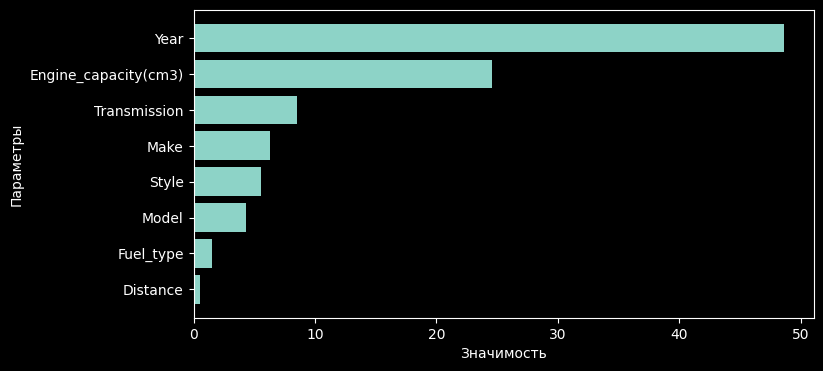

In [ ]:
feature_importance_plotter(model_reg, np.array(features_names))

## Оценка метрик

In [ ]:
def calculate_metric(model_pipe, X, y, metric = r2_score):
    """Расчет метрики.
    Параметры:
    ===========
    model_pipe: модель или pipeline
    X: признаки
    y: истинные значения
    metric: метрика (r2 - по умолчанию)
    """
    y_model = model_pipe.predict(X)
    return metric(y, y_model)

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(model_reg, train_data_reg, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(model_reg, eval_data_reg, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(model_reg, train_data_reg, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(model_reg, eval_data_reg, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.8281
r2 на валидационной выборке: 0.8294
mse на тренировочной выборке: 10450296.0707
mse на валидационной выборке: 10741386.9089


## Кросс-валидация

In [ ]:
def cross_validation (X, y, model, scoring, cv_rule):
    """Расчет метрик на кросс-валидации.
    Параметры:
    ===========
    model: модель или pipeline
    X: признаки
    y: истинные значения
    scoring: словарь метрик
    cv_rule: правило кросс-валидации
    """
    scores = cross_validate(model,X, y,
                      scoring=scoring, cv=cv_rule )
    print('Ошибка на кросс-валидации')
    DF_score = pd.DataFrame(scores)
    display(DF_score)
    print('\n')
    print(DF_score.mean()[2:])

In [ ]:
scoring_reg = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           '-Max': 'max_error'}

В принципе работает без сложностей и доп. телодвижений

In [ ]:
cross_validation (X_train, y_train,
                  model_reg,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

0:	learn: 5240.0559261	total: 13.7ms	remaining: 13.7s
100:	learn: 2432.1790146	total: 1.07s	remaining: 9.54s
200:	learn: 2145.4147910	total: 2.17s	remaining: 8.61s
300:	learn: 2033.0948877	total: 3.18s	remaining: 7.39s
400:	learn: 1969.4006914	total: 4.18s	remaining: 6.24s
500:	learn: 1925.7333452	total: 5.17s	remaining: 5.15s
600:	learn: 1895.9679068	total: 6.14s	remaining: 4.07s
700:	learn: 1874.3626524	total: 7.13s	remaining: 3.04s
800:	learn: 1853.5429424	total: 8.16s	remaining: 2.03s
900:	learn: 1836.0474063	total: 9.32s	remaining: 1.02s
999:	learn: 1817.1849222	total: 11.3s	remaining: 0us
0:	learn: 5210.5621362	total: 20.7ms	remaining: 20.7s
100:	learn: 2417.4529069	total: 1.29s	remaining: 11.5s
200:	learn: 2121.3342252	total: 2.35s	remaining: 9.35s
300:	learn: 2028.6806449	total: 3.34s	remaining: 7.76s
400:	learn: 1964.1303440	total: 4.34s	remaining: 6.49s
500:	learn: 1922.1708243	total: 5.36s	remaining: 5.33s
600:	learn: 1889.4670676	total: 6.32s	remaining: 4.2s
700:	learn: 186

,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,11.535767,0.021922,0.841411,-9.390346e+06,-1777.133593,-28868.550740
1,10.698956,0.024943,0.844429,-1.005867e+07,-1781.477778,-38545.874283
2,11.828093,0.010387,0.826299,-1.066391e+07,-1794.431797,-39750.768665
3,11.785918,0.011199,0.833388,-9.950977e+06,-1841.584587,-21690.035553
4,11.814038,0.010359,0.824318,-1.028873e+07,-1781.033373,-39889.435479




test_R2      8.339690e-01
test_-MSE   -1.007053e+07
test_-MAE   -1.795132e+03
test_-Max   -3.374893e+04
dtype: float64


## Визуализация ошибок от scikit-learn

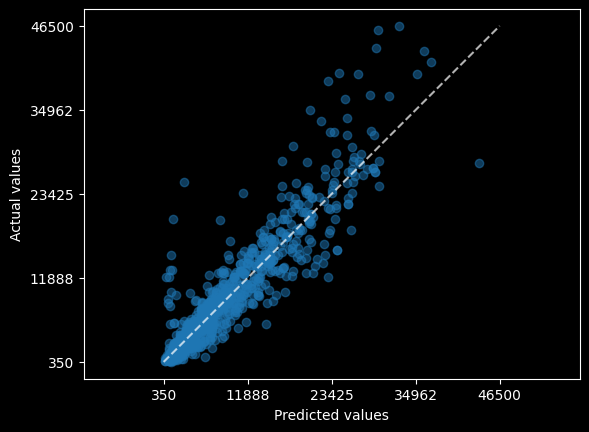

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model_reg.predict(eval_data_reg),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
        line_kwargs = {"color" : 'white'}

);

Небольшие выводы

* Модель регрессии от CatBoost уверенно превосходит всё, что было раньше, за исключением бустинга от sklearn

* Анализ значимости признаков говорит о том, что CatBoost предпочитает числовые признаки



# Дополнительная информация

## Полезность объектов

Есть возможность смотреть на проблемные объекты

`get_object_importance` - позволяет оценить влияние каждого элемента обучающей выборки на значение целевой метрики (`eval_metric`). В теории с помощью этого метода можно найти и избавиться от выбросов, шума и прочего.

Однако стоит предупредить что эта процедура может занимать продолжительное время

In [ ]:
# метод возвращает отсортированные списки индексов и скоров
idxs, scores = model_reg.get_object_importance(
    train_data_reg, eval_data_reg ,
    importance_values_sign="Positive"
)
len(idxs)

2196

In [ ]:
# Попробуем отбросить топ-100 найденных и посмотрим как изменится точность
train_pool = Pool(
    X_train.reset_index(drop=True).drop(idxs[:100]),
    y_train.reset_index(drop=True).drop(idxs[:100]),
    cat_features=cat_columns,
)

model_clean =  CatBoostRegressor(iterations = 1000,
                           early_stopping_rounds=100,
                           verbose = 100,
                           cat_features = cat_columns,
                           depth = 3,
                              objective  = 'MAE',
                           eval_metric= 'MAE',
                              random_state = 42
                           )

model_clean.fit(
    train_pool,
    eval_set=eval_data_reg,
    verbose=100,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

0:	learn: 5223.9883731	test: 5314.9998310	best: 5314.9998310 (0)	total: 17.9ms	remaining: 17.9s
100:	learn: 2432.0236742	test: 2490.0629998	best: 2490.0629998 (100)	total: 1.28s	remaining: 11.4s
200:	learn: 2134.6724560	test: 2166.4571371	best: 2166.4571371 (200)	total: 2.55s	remaining: 10.1s
300:	learn: 2030.5825884	test: 2055.8407620	best: 2055.8407620 (300)	total: 3.75s	remaining: 8.71s
400:	learn: 1967.1163254	test: 1990.0521760	best: 1990.0521760 (400)	total: 5.02s	remaining: 7.49s
500:	learn: 1924.5642256	test: 1947.1455792	best: 1947.1455792 (500)	total: 6.19s	remaining: 6.17s
600:	learn: 1890.3901918	test: 1913.5833131	best: 1913.5833131 (600)	total: 7.41s	remaining: 4.92s
700:	learn: 1863.0975597	test: 1887.1544174	best: 1887.1544174 (700)	total: 9.08s	remaining: 3.87s
800:	learn: 1841.6665100	test: 1869.6011490	best: 1869.6011490 (800)	total: 11.4s	remaining: 2.82s
900:	learn: 1821.2509939	test: 1852.9105368	best: 1852.9105368 (900)	total: 12.6s	remaining: 1.39s
999:	learn: 1

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(model_clean, train_data_reg, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(model_clean, eval_data_reg, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(model_clean, train_data_reg, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(model_clean, eval_data_reg, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.8315
r2 на валидационной выборке: 0.8329
mse на тренировочной выборке: 10246172.4290
mse на валидационной выборке: 10518667.4957


## Оптимизация гиперпараметров

Есть даже внутренняя оптимизация гиперпараметров, которая работает быстрее чем от sklearn (поскольку писалась под конкретный алгоритм обучения авторами)

In [ ]:
from scipy import stats

model = CatBoostRegressor(
    random_seed=42,
    thread_count=-1,
    cat_features=cat_columns,
    eval_metric="RMSE",
    verbose=500,
)

param_distribution = {
    "one_hot_max_size": stats.bernoulli(p=0.2, loc=2),
    "learning_rate": [0.03, 0.1, 0.3],
    "l2_leaf_reg": [2, 5, 7],
    "depth": stats.binom(n=10, p=0.2),
}
randomized_search_result = model.randomized_search(param_distribution, X_train, y_train)
model.best_score_

0:	learn: 11589.5365513	test: 11520.2731681	best: 11520.2731681 (0)	total: 7.84ms	remaining: 7.83s
500:	learn: 3469.0953167	test: 3440.8603255	best: 3440.8603255 (500)	total: 2.43s	remaining: 2.42s
999:	learn: 3319.0495188	test: 3335.8214929	best: 3335.8158718 (998)	total: 4.75s	remaining: 0us

bestTest = 3335.815872
bestIteration = 998

0:	loss: 3335.8158718	best: 3335.8158718 (0)	total: 4.81s	remaining: 43.3s
0:	learn: 11614.4721657	test: 11544.8329321	best: 11544.8329321 (0)	total: 4.4ms	remaining: 4.4s
500:	learn: 4345.5334270	test: 4284.0742547	best: 4284.0742547 (500)	total: 1.5s	remaining: 1.5s
999:	learn: 4272.3470593	test: 4209.6603528	best: 4209.6486751 (998)	total: 3.66s	remaining: 0us

bestTest = 4209.648675
bestIteration = 998

1:	loss: 4209.6486751	best: 3335.8158718 (0)	total: 8.5s	remaining: 34s
0:	learn: 11668.1987089	test: 11595.5505197	best: 11595.5505197 (0)	total: 4.3ms	remaining: 4.3s
500:	learn: 7803.9463339	test: 7774.0467552	best: 7773.7264692 (158)	total: 2.17

{'learn': {'RMSE': 2716.0056409649073}}

In [ ]:
# Лучшие параметры модели из перебора
randomized_search_result["params"]

{'depth': 4, 'one_hot_max_size': 2, 'learning_rate': 0.1, 'l2_leaf_reg': 5}

В ходе оптимизации метрики модели улучшились - и стали сопоставимыми с градиентным бустингом от sklearn

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(model, train_data_reg, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(model, eval_data_reg, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(model, train_data_reg, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(model, eval_data_reg, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.8796
r2 на валидационной выборке: 0.8626
mse на тренировочной выборке: 7320894.1133
mse на валидационной выборке: 8648385.2542


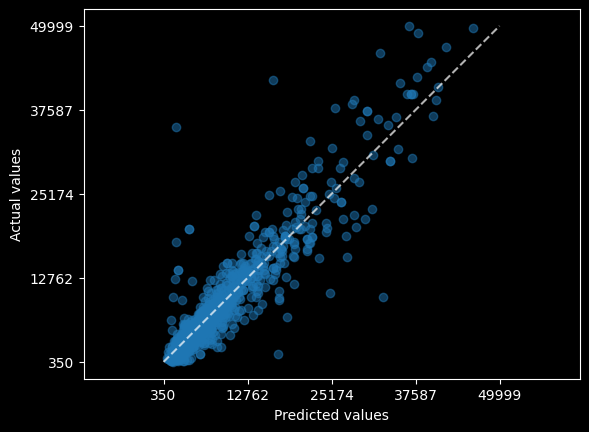

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model.predict(eval_data_reg),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
        line_kwargs = {"color" : 'white'}

);

# Сохранение / Загрузка

In [ ]:
# сохранение модели
model.save_model("catboost_model.cbm", format="cbm")  # есть свой формат данных

In [ ]:
# Загрузка модели
new_model = CatBoostRegressor()
new_model.load_model("catboost_model.cbm")

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(new_model, train_data_reg, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(new_model, eval_data_reg, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(new_model, train_data_reg, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(new_model, eval_data_reg, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.8796
r2 на валидационной выборке: 0.8626
mse на тренировочной выборке: 7320894.1133
mse на валидационной выборке: 8648385.2542
